<a href="https://colab.research.google.com/github/alextbradley/IceSheetModellingIntro/blob/main/Introduction_to_ice_sheet_modelling_lecture_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to ice sheet modelling lecture 2

Tipping point example based on [Alex Robel](https://eas.gatech.edu/people/robel-dr-alexander)'s code for the [Schoof 2007 model](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006JF000664).

## Instructions for installing Julia
This demo runs in Google Colab, a browser based notebook for Python. However, the code runs in Julia, so we have to install Julia on top of this. The instructions to do so are as follows:

1. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
2. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 1 and 2.
* You can check the installation by running the second cell (containing `versioninfo()`). If the installation has been successful, it should print your Julia version and some other info about the system.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-07-27 08:50:15 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...


In [ ]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


## Install Packages

In [ ]:
using Pkg

Pkg.add("ForwardDiff")
Pkg.add("Plots")
Pkg.add("Statistics")
Pkg.add("Distributions")
Pkg.add("NLsolve")
using ForwardDiff
using NLsolve
using Plots
using Statistics
using Distributions

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed IrrationalConstants ── v0.2.2
   Installed SpecialFunctions ───── v2.4.0
   Installed ChainRulesCore ─────── v1.24.0
   Installed StaticArrays ───────── v1.9.7
   Installed StaticArraysCore ───── v1.4.3
   Installed DiffRules ──────────── v1.15.1
   Installed DiffResults ────────── v1.1.0
   Installed NaNMath ────────────── v1.0.2
   Installed MacroTools ─────────── v0.5.13
   Installed Compat ─────────────── v4.15.0
   Installed LogExpFunctions ────── v0.3.28
   Installed OpenSpecFun_jll ────── v0.5.5+0
   Installed ChangesOfVariables ─── v0.1.8
   Installed ForwardDiff ────────── v0.10.36
   Installed DocStringExtensions ── v0.9.3
   Installed CommonSubexpressions ─ v0.3.0
   Installed InverseFunctions ───── v0.1.15
    Updating `~/.julia/environments/v1.8/Project.toml`
  [f6369f11] + ForwardDiff v0.10.36
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [d360d2e6] + Chai

In [ ]:
#Prescribed initial values of model parameters in a dictionary
function params_define()
    params = Dict()
    #params["b0"] = -100
    #params["bx"] = -1e-3
    params["A"] = 4e-26
    params["year"] = 3600 * 24 * 365
    params["n"] = 3
    params["C"] = 7.6e6
    params["rho_i"] = 900
    params["rho_w"] = 1000
    params["g"] = 9.8
    params["B"] = params["A"]^(-1 / params["n"])
    params["m"] = 1 / params["n"]
    params["accum"] = 0.3 / params["year"]

    #Scaling parameters
    params["hscale"] = 1000
    params["ascale"] = 0.1 / params["year"]
    params["uscale"] =(params["rho_i"] * params["g"] * params["hscale"] * params["ascale"] / params["C"])^(1 / (params["m"] + 1))
    params["xscale"] = params["uscale"] * params["hscale"] / params["ascale"]
    params["tscale"] = params["xscale"] / params["uscale"]
    params["eps"] = params["B"] * ((params["uscale"] / params["xscale"])^(1 / params["n"])) / (2 * params["rho_i"] * params["g"] * params["hscale"])
    params["lambda"] = 1 - (params["rho_i"] / params["rho_w"])

    #Grid parameters
    params["NT"] = 1
    params["TF"] = params["year"]
    params["dt"] = params["TF"] / params["NT"]
    params["transient"] = 0

    params["N1"] = 100
    params["N2"] = 400
    params["sigGZ"] = 0.97
    params["NX"] = params["N1"] + params["N2"]

    #sigma = vcat(LinRange(0, 1, convert(Integer, params["N1"])));
    sigma1=LinRange(params["sigGZ"]/(params["N1"]+0.5), params["sigGZ"], convert(Integer, params["N1"]))
    sigma2=LinRange(params["sigGZ"], 1, convert(Integer, params["N2"]+1))
    sigma = vcat(sigma1,sigma2[2:params["N2"]+1])
    grid = Dict("sigma" => sigma)
    grid["sigma_elem"] = vcat(0,(sigma[1:params["NX"]-1] + sigma[2:params["NX"]]) ./ 2)
    grid["dsigma"] = diff(grid["sigma"])
    return params, grid
end


params_define (generic function with 1 method)

In [ ]:
#Define bed topography function
function bed(x,params::Dict{Any,Any})
    729 .- 2184.8.*(x./750e3).^2 .+ 1031.72.*(x/750e3).^4 .- 151.72.*(x./750e3).^6
end

bed (generic function with 1 method)

In [ ]:
#implicit flowline model function
function flowline!(F, varin, varin_old, params, grid, bedfun::Function)
    #Unpack grid
    NX = params["NX"]
    N1 = params["N1"]
    dt = params["dt"]/params["tscale"]
    ds = grid["dsigma"]
    sigma = grid["sigma"]
    sigma_elem = grid["sigma_elem"]

    #Unpack parameters
    xscale = params["xscale"]
    hscale = params["hscale"]
    lambda = params["lambda"]
    m      = params["m"]
    n      = params["n"]
    a      = params["accum"]/params["ascale"]
    eps    = params["eps"]
    transient = params["transient"]

    #Unpack variables
    h = varin[1:NX]
    u = varin[NX+1:2*NX]
    xg = varin[2*NX+1]

    h_old = varin_old[1:NX]
    xg_old = varin_old[2*NX+1]

    #Calculate bed
    hf = -bedfun(xg*xscale,params)/(hscale*(1-lambda))
    hfm = -bedfun(xg*last(sigma_elem)*xscale,params)/(hscale*(1-lambda))
    b =  -bedfun(xg.*sigma.*xscale,params)./hscale

    #Calculate thickness functions
    F[1]      = transient*(h[1]-h_old[1])/dt + (2*h[1]*u[1])/(ds[1]*xg) - a
    F[2]      = transient*(h[2]-h_old[2])/dt -
                    transient*sigma_elem[2]*(xg-xg_old)*(h[3]-h[1])/(2*dt.*ds[2]*xg) +
                        (h[2]*(u[2]+u[1]))/(2*xg*ds[2]) - a
    F[3:NX-1] = transient.*(h[3:NX-1] .- h_old[3:NX-1])./dt .-
                    transient.*sigma_elem[3:NX-1].*(xg - xg_old).*(h[4:NX].-h[2:NX-2])./(2 .* dt .* ds[3:NX-1] .* xg) .+
                        (h[3:NX-1] .* (u[3:NX-1] .+ u[2:NX-2]) .- h[2:NX-2] .* (u[2:NX-2] .+ u[1:NX-3]))./(2 .* xg .* ds[3:NX-1]) .- a
    F[N1] = (1+0.5*(1+(ds[N1]/ds[N1-1])))*h[N1] - 0.5*(1+(ds[N1]/ds[N1-1]))*h[N1-1] - h[N1+1]
    F[NX]     = transient*(h[NX]-h_old[NX])/dt -
                    transient*sigma[NX]*(xg-xg_old)*(h[NX]-h[NX-1])/(dt*ds[NX-1]*xg) +
                        (h[NX]*(u[NX]+u[NX-1]) - h[NX-1]*(u[NX-1]+u[NX-2]))/(2*xg*ds[NX-1]) - a

    #Calculate velocity functions
    F[NX+1]      = (4*eps/(xg*ds[1])^((1/n)+1))*(h[2]*(u[2]-u[1])*abs(u[2]-u[1])^((1/n)-1) -
                  h[1]*(2*u[1])*abs(2*u[1])^((1/n)-1)) - u[1]*abs(u[1])^(m-1) -
                  0.5*(h[1]+h[2])*(h[2]-b[2]-h[1]+b[1])/(xg*ds[1])
    F[NX+2:2*NX-1] = (4 .* eps ./(xg .* ds[2:NX-1]).^((1/n)+1)) .* (h[3:NX] .* (u[3:NX] .- u[2:NX-1]) .* abs.(u[3:NX].-u[2:NX-1]).^((1/n)-1) .-
                  h[2:NX-1] .* (u[2:NX-1] .- u[1:NX-2]) .* abs.(u[2:NX-1] .- u[1:NX-2]).^((1/n)-1)) .-
                  u[2:NX-1] .* abs.(u[2:NX-1]).^(m-1) .- 0.5 .* (h[2:NX-1] .+ h[3:NX]) .* (h[3:NX] .- b[3:NX] .- h[2:NX-1] .+ b[2:NX-1])./(xg .* ds[2:NX-1])
    F[NX+N1] = (u[N1+1]-u[N1])/ds[N1] - (u[N1]-u[N1-1])/ds[N1-1]
    F[2*NX]     = (1/(xg*ds[NX-1])^(1/n))*(abs(u[NX]-u[NX-1])^((1/n)-1))*(u[NX]-u[NX-1]) - lambda*hf/(8*eps)

    #Calculate grounding line functions
    F[2*NX+1]        = 3*h[NX] - h[NX-1] - 2*hf
end

flowline! (generic function with 1 method)

In [ ]:
function Jac_calc(huxg_old, params, grid, bedfun::Function, flowlinefun::Function)
    #Use automatic differentiation to calculate Jacobian for nonlinear solver (more accurate and faster than finite difference!)
    f = varin -> (F = fill(zero(promote_type(eltype(varin), Float64)), 2*params["NX"]+1); flowlinefun(F, varin, huxg_old, params, grid, bedfun); return F)
    J = fill(0.0, 2*params["NX"]+1, 2*params["NX"]+1)
    Jf! = (J,varin) -> ForwardDiff.jacobian!(J, f, varin)
    return Jf!
end

function flowline_run(varin, params, grid, bedfun::Function, flowlinefun::Function)

    nt = params["NT"]
    huxg_old = varin

    for i in 1:nt
        Jf! = Jac_calc(huxg_old, params, grid, bedfun, flowlinefun)
        solve_result=nlsolve((F,varin) ->flowlinefun(F, varin, huxg_old, params, grid, bedfun), Jf!, huxg_old)
        huxg_old = solve_result.zero
        if !solve_result.f_converged
            err="Solver didn't converge at time step " * string(i)
            print(err)
        end
    end
    return huxg_old
end


flowline_run (generic function with 1 method)

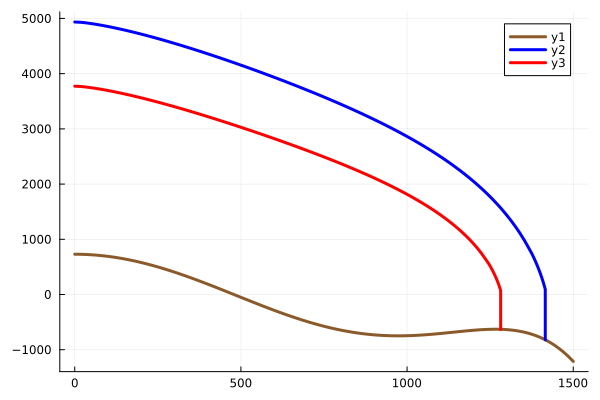

In [ ]:
#Initial guess
params, grid = params_define()
xg = 1400e3/params["xscale"]
hf = (-bed(xg*params["xscale"],params)/params["hscale"])/(1-params["lambda"])
h  = 5 .- (5-hf).*grid["sigma"]
u  = 10.0.*(grid["sigma_elem"].^(1/3)) .+ 1e-3
huxg_old = vcat(h,u,xg)

#Steady-state calc
huxg_out0 = flowline_run(huxg_old, params, grid, bed, flowline!)
params["accum"] = 0.01 / params["year"]
params["NT"] = 10
params["TF"] = params["year"]*10000
params["dt"] = params["TF"] / params["NT"]
params["transient"] = 1
huxg_out1 = flowline_run(huxg_out0, params, grid, bed, flowline!)
huxg_out2 = flowline_run(huxg_out1, params, grid, bed, flowline!)



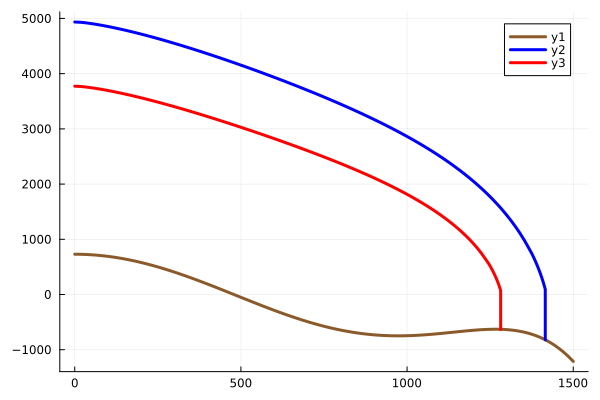

In [ ]:
# Plot stuff
x = LinRange(0,1500e3,convert(Integer, 1e3))

#steady state stuff
h0 = huxg_out0[1:params["NX"]].*params["hscale"];
xg0 = huxg_out0[2*params["NX"]+1].*params["xscale"];
hl0=vcat(h0.+bed(grid["sigma_elem"].*xg0,params),bed(xg0,params))
xl0=vcat(grid["sigma_elem"],1).*xg0./1e3


h1 = huxg_out1[1:params["NX"]].*params["hscale"];
xg1 = huxg_out1[2*params["NX"]+1].*params["xscale"];
hl1=vcat(h1.+bed(grid["sigma_elem"].*xg1,params),bed(xg1,params))
xl1=vcat(grid["sigma_elem"],1).*xg1./1e3

plot(x./1e3,bed(x,params),lw=3,linecolor=:tan4)
plot!(xl0,hl0,lw=3,linecolor=:blue)
plot!(xl1,hl1,lw=3,linecolor=:red)